# Two Point Eyring Plot

**NOTE: This version of the workbook has code for more formal plots.**

This notebook will present plots of the Erying plot for the brosylates..

The data being plotted is from Table 1 in “Neighboring Carbon and Hydrogen. VII. Reactivity of Some Alicyclic and Bicyclic Derivatives” 
S. Winstein, B.K. Morse, E. Grunwald, H.W. Jones, J. Corse, D. Trifan, H. Marshall, 
*J. Am. Chem. Soc.*, **1952**, *74*, 1127–1132. 
https://doi.org/10.1021/ja01125a003.




## Setup Tools and Read Data Table

Here the data table is read in and processed. Also the libraries are imported and any functions defined

In [5]:
### SETUP

#!pip install uncertainties
#!pip install lmfit
#!mkdir plots

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.optimize import curve_fit

import uncertainties as un
from uncertainties import unumpy as unp

import lmfit

github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Winstein/"
github_location = ""
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"



## Read Data

Read the data in from the csv text file.

[347.65 323.15] [1.54e-04 8.16e-06] [2.e-06 6.e-08]
---------- FIT REPORT ------------
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 2
    # variables        = 2
    chi-square         = 2.5216e-25
    reduced chi-square = 2.5216e-25
    Akaike info crit   = -110.665754
    Bayesian info crit = -113.279460
    R-squared          = 1.00000000
[[Variables]]
    m: -13135.5622 +/- 3.4364e-11 (0.00%) (init = -1000)
    b:  23.1541153 +/- 1.0457e-13 (0.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, b) = -0.9995
RSQ = 1.000

      _BEST_
 m:-13135.56223
 b:  23.15412
------THERMODYNAMIC PARAMETERS----------
The change in enthalpy is 109215.14+/-0.00 J/mole 23.15411531713171+/-0.00000000000010
The change in entropy is -5.04+/-0.00 J/mole.K -13135.562231406398+/-0.000000000034

-------- CHECK FIT ----------
calculate k at T=298 K is (2.436+/-0.000)e-07
[298.15 306.85] [8.79e-0

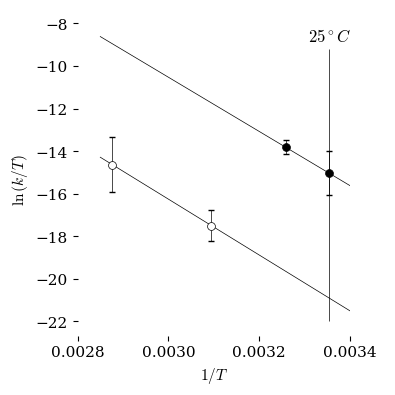

In [8]:
## EYRING PLOT
# 

import scipy.constants
size = [4,4]

sigma = 2


######################
### Experimental data with error
######################

temp_endo = np.array([74.5, 50.0]) + 273.15       # list of temperatures
k_obs_endo = np.array([15.4, 0.816]) * 1e-5  # list of observe rate constants (s^-1)
k_obs_err_endo= np.array([0.2 , 0.006]) * 1e-5  # list of standard deviations for data

temp_exo = np.array([25.0, 33.7]) + 273.15      # list of temperatures
k_obs_exo = np.array([8.79, 30.4]) * 1e-5 # list of observe rate constants (s^-1)
k_obs_err_exo= np.array([0.09 , 0.1]) * 1e-5  # list of standard deviations for data


temp = temp_endo
k_obs = k_obs_endo
k_obs_err = k_obs_err_endo

print(temp, k_obs, k_obs_err)

### Convert lists to numpy arrays (enables numpy math tools with these lists)
k_obs = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/(temp)  # convert temperature to Kelvin and then to 1/T
y_u = unp.log(k_obs/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function  

# load the function f as the model to be fit
mod = lmfit.Model(linear)       

# state the parameters (use the text strings that we used above in the 
#   function) initial values are also set here
pars = mod.make_params(m=-1000, b=0  )     
                                            
# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, x=x, weights=1.0/y_err)   




print("---------- FIT REPORT ------------")
print(result.fit_report())

r,p = scipy.stats.pearsonr(x,y); rsq = r**2
print(f"RSQ = {rsq:0.3f}")
print()

#print("--- PARAMETER CONFIDENCE INTERVALS ----")
print(result.ci_report())
#print()

intercept = result.uvars['b']      # collect parameters as uncertain values 
slope = result.uvars['m']

temp_test = 298
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - unp.log(kb/h)) * R

print("------THERMODYNAMIC PARAMETERS----------")
print(f"The change in enthalpy is {dH:0.2f} J/mole {intercept}")
print(f"The change in entropy is {dS:0.2f} J/mole.K {slope}")
print()

## calculate k from Erying plot parameters.
kobs = (kappa * kb / h) * temp_test * unp.exp(-dH/(R*temp_test)) * unp.exp(dS/R)
print("-------- CHECK FIT ----------")
print(f"calculate k at T={temp_test} K is {kobs:0.4g}")


#################################################################

plt.rcdefaults()
style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(figsize = size)

ax.errorbar(x, y, yerr=y_err*100, fmt='none', ecolor='black', elinewidth=0.5, capsize=2, zorder=3)
ax.scatter(x, y, linewidths=0.5, marker="o", s=32, facecolors="white", edgecolors="black", zorder=3)

max_x = 0.0034
min_x = 0.00285
x_fit = np.linspace(min_x, max_x, 100)  # x values for the fit line
y_fit = result.eval(x=x_fit)  # evaluate the fit line at these x values
ax.plot(x_fit, y_fit, linewidth=0.5, color="black", zorder=2)
        
##################################
### Second Exo Plot
##################################

temp = temp_exo
k_obs = k_obs_exo
k_obs_err = k_obs_err_exo

print(temp, k_obs, k_obs_err)

### Convert lists to numpy arrays (enables numpy math tools with these lists)
k_obs = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/(temp)  # convert temperature to Kelvin and then to 1/T
y_u = unp.log(k_obs/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################

### Use curve_fit function  

# load the function f as the model to be fit
mod = lmfit.Model(linear)       

# state the parameters (use the text strings that we used above in the 
#   function) initial values are also set here
pars = mod.make_params(m=-1000, b=0  )     
                                            
# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, x=x, weights=1.0/y_err)   




print("---------- FIT REPORT ------------")
print(result.fit_report())

r,p = scipy.stats.pearsonr(x,y); rsq = r**2
print(f"RSQ = {rsq:0.3f}")
print()

#print("--- PARAMETER CONFIDENCE INTERVALS ----")
print(result.ci_report())
#print()

intercept = result.uvars['b']      # collect parameters as uncertain values 
slope = result.uvars['m']

temp_test = 298
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - unp.log(kb/h)) * R

print("------THERMODYNAMIC PARAMETERS----------")
print(f"The change in enthalpy is {dH:0.2f} J/mole ")
print(f"The change in entropy is {dS:0.2f} J/mole.K ")
print()

## calculate k from Erying plot parameters.
kobs = (kappa * kb / h) * temp_test * unp.exp(-dH/(R*temp_test)) * unp.exp(dS/R)
print("-------- CHECK FIT ----------")
print(f"calculate k at T={temp_test} K is {kobs:0.4g}")


#################################################################

ax.errorbar(x, y, yerr=y_err*100, fmt='none', ecolor='black', elinewidth=0.5, capsize=2, zorder=3)

ax.scatter(x, y, linewidths=0.5, marker="o", s=32, facecolors="black",
        edgecolors="black", zorder=3
)

y_fit = result.eval(x=x_fit)  # evaluate the fit line at these x values
ax.plot(x_fit, y_fit, linewidth=0.5, color="black", zorder=2)


ax.set(xlabel = r"$1/T$",
       ylabel = r"$\ln \left( k/T \right)$"
)

ax.set_xticks([0.0028,0.0030,0.0032,0.0034])  # These will be the ticks for both axes
ax.set_xlim([0.0028, max_x])

ax.vlines(1/298.15, -22, -9.2, color='black', linewidth=0.5, zorder=1)
ax.text(1/298.15, -9, r"$25 ^\circ C$", 
        horizontalalignment='center', verticalalignment='bottom', 
        color='black', fontsize=12, zorder=1
)
##################################





### do not show legend 
fig.legend([])
plt.legend([])      # blank legend

plt.savefig("eyring.pdf")
plt.show()


In [3]:
import scipy.constants

scipy.constants.

SyntaxError: invalid syntax (579534893.py, line 3)

## Bootstrap Line Fit parameters

Here I will attempt a completely inappropriate smooth bootstrap algorithm. The code below is based on the bootstrap code presented in my annual "Why you should use *Python* seminar".  You can find that code in my github repository at https://blinkletter.github.io/PythonPresentation/start.html



### Setup

The code block below contains the global variables and functions used in the algorith and the plot settings for MatPlotLib.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy.constants

import uncertainties as un
from uncertainties import unumpy as unp

import lmfit

github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Winstein/"
github_location = ""
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"


#######################################
## Global variables
#######################################

sigma_range = 1           # Confidence for report. 1 sigma:68%, 2 sigma:95%, 3 sigma:99$
sigma_plot = 3            # Confidence for plot image. 1 sigma:68%, 2 sigma:95%, 3 sigma:99$
boot_n = 2000             # Number of bootstrap resamples

#######################################
## Global variables for plots
#######################################

x_lim_1 = [0.00277,0.0034]
y_lim_1 = [-22.5,-6]

x_lim_2 = [-0.0002, 0.004]
y_lim_2 = [-22,30]

x_ticks_1 = [0.0028,0.0030,0.0032,0.0034]
y_ticks_1 = [-22,-18,-14,-10,-6]

x_ticks_2 = [0,0.001,0.002,0.003,0.004]
y_ticks_2 = [-20,-10,0,10,20,30]

x_for_ci_min = x_ticks_1[0]       # Minimum x value for confidence interval
x_for_ci_max = x_ticks_1[-1]      # Maximum x value for confidence interval

x0_for_ci_min = x_ticks_2[0]      # Minimum x value for confidence interval starting at zero
x0_for_ci_max = x_ticks_2[-1]     # Maximum x value for confidence interval starting at zero


#######################################
## Set up functions for curve fit and thermodynamic calculations
#######################################

def linear(x, slope, intercept):     # Linear function for line fitting
    return slope * x + intercept

def eyring_calc(slope, intercept):   # Calculate thermodynamic parameters
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1
    
    dH = -slope * R
    dS = (intercept - unp.log(kb/h)) * R
    return dH, dS

def report(bs, sigma_range = 1, testtemp = 298.15):
    #######################################
    ## Define confidence percentile limits
    #######################################

    sigma_dict = {1:68.3, 2:95.5, 3:99.7}      

    conf = sigma_dict[sigma_range]
    low_p = 50 - conf/2
    high_p = 50 + conf/2

    #######################################
    ### Report
    #######################################
    
    print(f"Confidence level = {conf}%")
    print()
    
    numbers = unp.nominal_values(bs["slope_list"])
    top_slope = np.percentile(numbers, high_p)
    bot_slope = np.percentile(numbers, low_p)
    median_slope = np.median(numbers)
    
    print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
    print(f"median slope in bootstrap population is {median_slope:0.1f} + "
          + f"{top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}"
          )
    print(f"best fit value for slope is {slope_u:0.1f}")
    print()
    
    numbers = unp.nominal_values(bs["intercept_list"])
    top_intercept = np.percentile(numbers, high_p)
    bot_intercept = np.percentile(numbers, low_p)
    median_intercept = np.median(numbers)
    
    print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
    print(f"median intercept in bootstrap population is {median_intercept:0.2f} + "
          + f"{top_intercept-median_intercept:0.2f} - "
          + f"{median_intercept-bot_intercept:0.2f}"
          )
    print(f"best fit value for intercept is {intercept_u:0.2f}")
    print()
    
    dH, dS = eyring_calc(slope_u, intercept_u)
    
    numbers = unp.nominal_values(bs["dH_list"])
    top_dH = np.percentile(numbers, high_p)
    bot_dH = np.percentile(numbers, low_p)
    median_dH = np.median(numbers)
    
    print(f"delta H range is {bot_dH:0.2f} to {top_dH:0.2f}")
    print(f"median delta H in bootstrap population is {median_dH:0.2f} + " 
          + f"{top_dH-median_dH:0.2f} - {median_dH-bot_dH:0.2f}"
          )
    print(f"best fit value for delta H is {dH:0.2f}")
    print()
    
    numbers = unp.nominal_values(bs["dS_list"])
    top_dS = np.percentile(numbers, high_p)
    bot_dS = np.percentile(numbers, low_p)
    median_dS = np.median(numbers)
    
    print(f"delta S range is {bot_dS:0.2f} to {top_dS:0.2f}")
    print(f"median delta S in bootstrap population is {median_dS:0.2f} + "
          + f"{top_dS-median_dS:0.2f} - {median_dS-bot_dS:0.2f}")
    print(f"best fit value for delta S is {dS:0.2f}")
    print()
    
    ########

    testy = linear(1/testtemp, slope_u.n, intercept_u.n)
    
    numbers_slope = unp.nominal_values(bs["slope_list"])
    numbers_int = unp.nominal_values(bs["intercept_list"])
    testy = linear(1/testtemp, numbers_slope, numbers_int)
    testkobs = np.exp(testy)*testtemp
    
    top_kobs = np.percentile(testkobs, high_p)
    bot_kobs = np.percentile(testkobs, low_p)
    median_kobs = np.median(testkobs)
    
    print(f"k_obs range is {bot_kobs:0.3g} to {top_kobs:0.3g}")
    print(f"median k_obs in bootstrap population is {median_kobs:0.3g} + "
          + f"{top_kobs-median_kobs:0.3g} - {median_kobs-bot_kobs:0.3g}")
    #print(f"best fit value for k_obs is {dS:0.2f}")
    print()
    
def bootstrap(t, k, k_err, boot_n, 
          x_for_ci_min, x_for_ci_max,
          x0_for_ci_min, x0_for_ci_max):

    ### Convert lists to numpy arrays (enables numpy math tools with these lists)

    temp = np.array(t)             # an array of float values
    k = unp.uarray(k, k_err)  # make an array of ufloat values
    
    ### Calculate x, y values and the uncertainty y_err using the
    ###   error propagation provided by the *uncertainties* package
    
    x = 1/temp                        # 1/T
    y_u = unp.log(k/temp)             # ln(k/T) uncertain array for y-axis
    
    ### Separate the uncertain y value into y and y_err for use in the curve_fit 
    
    y = unp.nominal_values(y_u)      # extract arrays of nominal values and errors
    y_err = unp.std_devs(y_u)        #   because curve_fit can't handle ufloats

    ################################################################################
    ### SMOOTH BOOTSTRAP 
    ### 
    ### Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction
    ################################################################################
    
    
    #######################################
    ## Bootstrap - Calculate a list of line fits for resampled data sets.
    #######################################
    
    slope_list = []           # A list of slopes from each iteration of bootstrap
    intercept_list = []       # A list of intercepts
    
    dS_list = []
    dH_list = []
    
    x_for_ci = np.linspace(x_for_ci_min, x_for_ci_max, 100)    # Array of x values 
    x0_for_ci = np.linspace(x0_for_ci_min, x0_for_ci_max, 100) # Array of x values starting at zero
    
    y_list = []               # A list of predicted values at each data point
    y_for_ci = []             # A list of sets of predicted values at each x point                     
    y0_for_ci = []            # A list of sets of predicted values at each x0 point
    
    for i in range(0, boot_n):
        x_s = x                            # Get x and y values from random pick
        y_s = np.random.normal(y, y_err)   # smooth with gaussian error 
    
        popt,pcov = curve_fit(linear, x_s, y_s)    # Curve fit the resampled data
    
        [slope, intercept] = popt
        slope_list.append(slope)
        intercept_list.append(intercept)
    
        dH, dS = eyring_calc(slope, intercept)
        dH_list.append(dH)
        dS_list.append(dS)
    
        y_list.append(linear(x, *popt))            # Predict y at data points 
        y_for_ci.append(linear(x_for_ci, *popt))   # Predict y along data range 
        y0_for_ci.append(linear(x0_for_ci, *popt)) # Predict y from 0 to data range 
    
    # Convert these lists of arrays to arrays of arrays (a matrix)
    y_list = np.array(y_list)
    y_for_ci = np.array(y_for_ci)    
    y0_for_ci = np.array(y0_for_ci)
    
    ### Package up data into a dictionary object (for convenience)
    
    bs = {
        "y_list": y_list,
        "x_for_ci": x_for_ci,
        "y_for_ci": y_for_ci,
        "x0_for_ci": x0_for_ci,
        "y0_for_ci": y0_for_ci,
        "slope_list": slope_list,
        "intercept_list": intercept_list,
        "dH_list": dH_list,
        "dS_list": dS_list
    }
    return bs, [x,y,y_err]


### Enter Data

Enter the data directly below using lists

In [3]:
########################################
### Enter Data
#########################################

temp_endo = np.array([74.5, 50.0]) + 273.15       # list of temperatures
k_obs_endo = np.array([15.4, 0.816]) * 1e-5  # list of observe rate constants (s^-1)
k_obs_err_endo = np.array([0.2 , 0.006]) * 1e-5  # list of standard deviations for data

temp_exo = np.array([25.0, 33.7]) + 273.15      # list of temperatures
k_obs_exo = np.array([8.79, 30.4]) * 1e-5 # list of observe rate constants (s^-1)
k_obs_err_exo = np.array([0.09 , 0.1]) * 1e-5  # list of standard deviations for data

### Make the Plot

/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_28906/3474454124.py:203: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(linear, x_s, y_s)    # Curve fit the resampled data
/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_28906/398877327.py:53: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(linear, x, y,     # Final curve fit of original data
/opt/anaconda3/envs/main/lib/python3.12/site-packages/uncertainties/core.py:170: RuntimeWarning: invalid value encountered in divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],


----------------------------
------------ENDO------------
----------------------------

Confidence level = 68.3%

slope range is -13064.1 to -13201.9
median slope in bootstrap population is -13131.1 + 66.9 - 70.9
best fit value for slope is -13135.6+/-nan

intercept range is 23.36 to 22.94
median intercept in bootstrap population is 23.14 + 0.22 - 0.20
best fit value for intercept is 23.15+/-nan

delta H range is 108621.15 to 109766.85
median delta H in bootstrap population is 109177.76 + 589.09 - 556.61
best fit value for delta H is 109215.14+/-nan

delta S range is -6.84 to -3.35
median delta S in bootstrap population is -5.15 + 1.80 - 1.68
best fit value for delta S is -5.04+/-nan

k_obs range is 2.44e-07 to 2.55e-07
median k_obs in bootstrap population is 2.49e-07 + 5.52e-09 - 5.67e-09



/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_28906/398877327.py:167: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(linear, x, y,     # Final curve fit of original data


----------------------------
------------EXO-------------
----------------------------

Confidence level = 68.3%

slope range is -12638.7 to -12861.1
median slope in bootstrap population is -12747.6 + 108.9 - 113.5
best fit value for slope is -12745.8+/-nan

intercept range is 28.09 to 27.36
median intercept in bootstrap population is 27.72 + 0.38 - 0.35
best fit value for intercept is 27.71+/-nan

delta H range is 105083.65 to 106932.82
median delta H in bootstrap population is 105989.20 + 943.62 - 905.56
best fit value for delta H is 105974.65+/-nan

delta S range is 29.95 to 36.02
median delta S in bootstrap population is 32.90 + 3.12 - 2.95
best fit value for delta S is 32.87+/-nan

k_obs range is 8.7e-05 to 8.88e-05
median k_obs in bootstrap population is 8.79e-05 + 9.13e-07 - 8.51e-07

Confidence level for plots = 99.7%


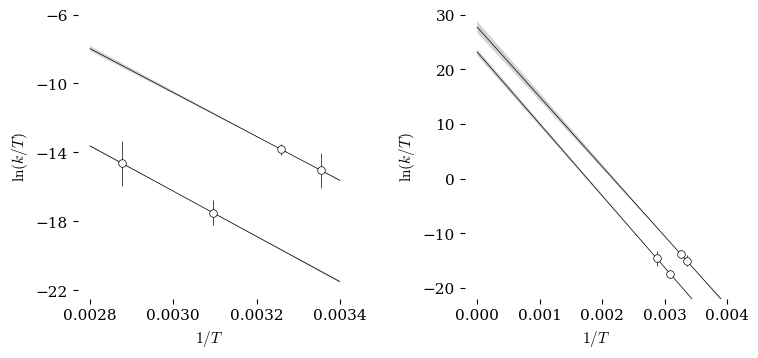

In [25]:
#######################################
### Create plot figure and axes
#######################################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim = x_lim_1,                  
          ylim = y_lim_1,
          xticks = x_ticks_1,
          yticks = y_ticks_1
       )

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim = x_lim_2,                  
          ylim = y_lim_2,
          xticks = x_ticks_2,
          yticks = y_ticks_2
       )

########################################
### Bootstrap parameters for endo case
#########################################

temp = temp_endo
k_obs = k_obs_endo
k_obs_err = k_obs_err_endo

bs={}
bs, [x,y,y_err] = bootstrap(temp, k_obs, k_obs_err, boot_n, 
          x_for_ci_min, x_for_ci_max,
          x0_for_ci_min, x0_for_ci_max)


#######################################
## Traditional Curve Fit for Comparison
#######################################

popt,pcov = curve_fit(linear, x, y,     # Final curve fit of original data
           #           sigma = y_err, absolute_sigma=False  # Include exp err
                     )
[slope_u, intercept_u] = un.correlated_values(popt, pcov) # Create new ufloat objects from returned parameters and covariance matrix 

#######################################
### Report
#######################################
print("----------------------------")
print("------------ENDO------------")
print("----------------------------")
print()

report(bs, sigma_range = sigma_range, testtemp = 298.15)

#######################################
### Other plot
#######################################

ax[0].scatter(x,y, marker='o', s = 30, 
              color='white', edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', s = 30, 
              color='white', edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=100*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
            #   capsize=2, capthick=0.5, 
               zorder=2)
ax[1].errorbar(x, y, yerr=100*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
            #   capsize=2, capthick=0.5, 
               zorder=2)

#######################################
### Confidence Interval as Stacked Faint Lines the Add Up to a Filled Shape
#######################################

#for line in bs["y_for_ci"]:
#    ax[0].plot(bs["x_for_ci"], line, 
#               color='lightgrey', linewidth = 0.5, alpha=.05, zorder=1)
#for line in bs["y0_for_ci"]:
#    ax[1].plot(bs["x0_for_ci"], line, 
#               color='lightgrey', linewidth = 0.5, alpha=.05, zorder=1)

#######################################
### Confidence Interval as Filled Shape
#######################################

sigma_dict = {1:68.3, 2:95.5, 3:99.7}     
conf = sigma_dict[sigma_plot]
low_p = 50 - conf/2
high_p = 50 + conf/2

top_y = []
bot_y = []
med_y = []

for n in range(len(bs["x_for_ci"])):
    top_y.append(np.percentile(bs["y_for_ci"][:,n], high_p))
    bot_y.append(np.percentile(bs["y_for_ci"][:,n], low_p))
    med_y.append(np.percentile(bs["y_for_ci"][:,n], 50))

ax[0].fill_between(bs["x_for_ci"], top_y, bot_y, 
                   facecolor="lightgrey", alpha=1, zorder = 0,
                   label="confidence interval")

top_y = []
bot_y = []
med_y = []

for n in range(len(bs["x0_for_ci"])):
    top_y.append(np.percentile(bs["y0_for_ci"][:,n], high_p))
    bot_y.append(np.percentile(bs["y0_for_ci"][:,n], low_p))
    med_y.append(np.percentile(bs["y0_for_ci"][:,n], 50))

ax[1].fill_between(bs["x0_for_ci"], top_y, bot_y, 
                   facecolor="lightgrey", alpha=1, zorder = 0,
                   label="confidence interval")


#######################################
### Plot Best Fit
#######################################

ax[0].plot(bs["x_for_ci"], linear(bs["x_for_ci"], slope_u.n, intercept_u.n), 
           color='black', linewidth = 0.5, zorder=4)
ax[1].plot(bs["x0_for_ci"], linear(bs["x0_for_ci"], slope_u.n, intercept_u.n), 
           color='black', linewidth = 0.5, zorder=4)



################################################################################
################################################################################
################################################################################
################################################################################
################################################################################

########################################
### Bootstrap parameters for exo case
#########################################

temp = temp_exo
k_obs = k_obs_exo
k_obs_err = k_obs_err_exo

bs={}
bs, [x,y,y_err] = bootstrap(temp, k_obs, k_obs_err, boot_n, 
          x_for_ci_min, x_for_ci_max,
          x0_for_ci_min, x0_for_ci_max)

#######################################
## Traditional Curve Fit for Comparison
#######################################

popt,pcov = curve_fit(linear, x, y,     # Final curve fit of original data
           #           sigma = y_err, absolute_sigma=False  # Include exp err
                     )
[slope_u, intercept_u] = un.correlated_values(popt, pcov)  # Create new ufloat objects from returned parameters and covariance matrix 


#######################################
### Report
#######################################

print("----------------------------")
print("------------EXO-------------")
print("----------------------------")
print()

report(bs, sigma_range = sigma_range, testtemp = 298.15)

#######################################
### Other plot
#######################################

ax[0].scatter(x,y, marker='o', s = 30, 
              color='white', edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', s = 30, 
              color='white', edgecolor='black', linewidth = 0.5, zorder=5)
ax[0].errorbar(x, y, yerr=100*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
            #   capsize=2, capthick=0.5, 
               zorder=2)
ax[1].errorbar(x, y, yerr=100*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
            #   capsize=2, capthick=0.5, 
               zorder=2)


#######################################
### Confidence Interval as Stacked Faint Lines the Add Up to a Filled Shape
#######################################

#for line in bs["y_for_ci"]:
#    ax[0].plot(bs["x_for_ci"], line, 
#               color='lightgrey', linewidth = 0.5, alpha=.05, zorder=1)
#for line in bs["y0_for_ci"]:
#    ax[1].plot(bs["x0_for_ci"], line, 
#               color='lightgrey', linewidth = 0.5, alpha=.05, zorder=1)

#######################################
### Confidence Interval as Filled Shape
#######################################

sigma_dict = {1:68.3, 2:95.5, 3:99.7}     
conf = sigma_dict[sigma_plot]
low_p = 50 - conf/2
high_p = 50 + conf/2

top_y = []
bot_y = []
med_y = []

for n in range(len(bs["x_for_ci"])):
    top_y.append(np.percentile(bs["y_for_ci"][:,n], high_p))
    bot_y.append(np.percentile(bs["y_for_ci"][:,n], low_p))
    med_y.append(np.percentile(bs["y_for_ci"][:,n], 50))

ax[0].fill_between(bs["x_for_ci"], top_y, bot_y, 
                   facecolor="lightgrey", alpha=1, zorder = 0,
                   label="confidence interval")

top_y = []
bot_y = []
med_y = []

for n in range(len(bs["x0_for_ci"])):
    top_y.append(np.percentile(bs["y0_for_ci"][:,n], high_p))
    bot_y.append(np.percentile(bs["y0_for_ci"][:,n], low_p))
    med_y.append(np.percentile(bs["y0_for_ci"][:,n], 50))

ax[1].fill_between(bs["x0_for_ci"], top_y, bot_y, 
                   facecolor="lightgrey", alpha=1, zorder = 0,
                   label="confidence interval")



#######################################
### Plot Best Fit Lines
#######################################

ax[0].plot(bs["x_for_ci"], linear(bs["x_for_ci"], slope_u.n, intercept_u.n), 
           color='black', linewidth = 0.5, zorder=4)
ax[1].plot(bs["x0_for_ci"], linear(bs["x0_for_ci"], slope_u.n, intercept_u.n), 
           color='black', linewidth = 0.5, zorder=4)

################################################################################
################################################################################
################################################################################
################################################################################
################################################################################


#######################################
### Output plot
#######################################

print(f"Confidence level for plots = {conf}%")

plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)

plt.savefig("bootstrap.pdf")
plt.savefig("bootstrap.png", dpi=300)
plt.show()



### Old Code

